# Table Of Content
[installation of dependencies](#install_deps)  
[installation of main package](#install_main)  
[starting the notebook](#start)  
[download test data](#download)  
[GAMMA: DEM preparation](#gamma_demprep)  
[GAMMA: processing](#gamma_proc)  
[SNAP: DEM preparation](#snap_demprep)  
[SNAP: processing](#snap_proc)  
[CORINE preparation](#corine)  
[Plots](#plots)  
[Todo](#todo) 

# prerequisites
In some of the following cells directories and files are going to be created. The currect structure is organized such that a main directory exists in which the sub-directories and files are stored.  
Files specific to a Sentinel-1 scene will contain a unique prefix in their name, which consists of the sensor identifier, the acquisition mode, the orbit and the acquisition start time.  
The code directory can be used to clone the GitHub repository ( see later step).  
The following describes an exemplary structure with directories in bold letters.  
* **S1_ARD**
  * **data**
    * **CORINE**
      * e.g. ```clc2018_clc2018_V2018.20b2.tif```
    * **DEM**
      * e.g. ```S1A__IW___A_20180829T170656_dem_gamma_AW3D30```
    * **GAMMA**
      * **e.g. ```S1A__IW___A_20180829T170656_AW3D30```**
        * e.g. ```S1A__IW___A_20180829T170656_VV_grd_mli_norm_geo_db.tif```
    * **SNAP**
      * **e.g. ```S1A__IW___A_20180829T170656_AW3D30```**
        * e.g. ```S1A__IW___A_20180829T170656_VV_bnr_Orb_Cal_TF_TC_dB.tif```
    * e.g. ```S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip```
  * **code**
    * **.git**
    * **S1_ARD**
    * data_prepare.ipynb
    * ..


Define main directory in Python:

In [5]:
maindir = '/home/john/Desktop/S1_ARD/data'

<a id='install_deps'></a>
# install the current spatialist and pyroSAR development branches

```shell
# install git for package versioning
sudo apt-get install git

# uninstall in case the packages have been installed before
python -m pip uninstall spatialist pyroSAR

# install the latest package development versions
python -m pip install git+https://github.com/johntruckenbrodt/spatialist.git@master
python -m pip install git+https://github.com/johntruckenbrodt/pyroSAR.git@master
```

<a id='install_main'></a>
# install/update the S1_ARD package

```shell
# change to the code sub-directory
cd code

# (first start only) clone the GitHub repository
git clone https://github.com/johntruckenbrodt/S1_ARD.git

# change into the cloned directory
cd S1_ARD

# update the project if it has been cloned before
git pull

# install additional dependencies
python -m pip install -r requirements.txt

# add the code location to the PATH environment
export PATH=$PATH:$(pwd)

# change back to main dir
cd ../..
```
## Note
For convenience the code location is best permanently added to the PATH environment by adding a line to the .bashrc file:
```shell
export PATH=$PATH:/path/to/S1_ARD/code
```

<a id='start'></a>
# starting the notebook

```shell
# first start jupyter and then select the notebook from the browser menu
jupyter notebook
```

<a id='download'></a>
# download test data

```shell
# change to the data directory
cd data

wget -c -T120 --no-check-certificate --user="username" --password="password" \
-O S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip \
"https://scihub.copernicus.eu/dhus/odata/v1/Products('1d498b6b-f890-4c3f-a30e-877338e9f2fe')/\$value"
```

<a id='gamma_demprep'></a>
# GAMMA: DEM preparation

documentation:
- [pyroSAR.identify](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.drivers.identify)
- function dem_autocreate is not documented on readthedocs yet, but a docstring can be called in Python: `help(dem_autocreate)`
- the download of TanDEM-X 90m DEMs requires a registration, see [here](https://geoservice.dlr.de/web/dataguide/tdm90) for details; once registered the credentials can be passed to function dem_autocreate; for the other DEM options they are ignored

In [6]:
import os
import pyroSAR
from pyroSAR import identify
from pyroSAR.gamma.srtm import dem_autocreate

filename = os.path.join(maindir, 'S1A_IW_GRDH_1SDV_20180829T170656_20180829T170721_023464_028DE0_F7BD.zip')

id = identify(filename)

print(id)
print('-' * 20)
demfiles = {}
for demType in ['AW3D30', 'SRTM 1Sec HGT', 'SRTM 3Sec', 'TDX90m']:
    dem_id = demType.replace(' ', '-')
    dem_base = '{}_dem_gamma_{}'.format(id.outname_base(), dem_id)
    dem_dir = os.path.join(maindir, 'DEM')
    if not os.path.isdir(dem_dir):
        os.makedirs(dem_dir)
    dem = os.path.join(dem_dir, dem_base)
    print(demType)
    with id.bbox() as bbox:
        dem_autocreate(geometry=bbox, 
                       demType=demType, 
                       outfile=dem, 
                       buffer=0.01,
                       username='username', 
                       password='password')
    demfiles[dem_id] = dem
    print('-' * 10)

pyroSAR ID object of type SAFE
acquisition_mode: IW
cycleNumber: 148
frameNumber: 167392
lines: 16703
orbit: A
orbitNumber_abs: 23464
orbitNumber_rel: 117
polarizations: ['VV', 'VH']
product: GRD
projection: +proj=longlat +datum=WGS84 +no_defs 
samples: 26056
sensor: S1A
spacing: (10.0, 10.0)
start: 20180829T170656
stop: 20180829T170721
--------------------
AW3D30
outfile already exists
----------
SRTM 1Sec HGT
outfile already exists
----------
SRTM 3Sec
outfile already exists
----------
TDX90m
outfile already exists
----------


<a id='gamma_proc'></a>
# GAMMA: processing

documentation:
- [pyroSAR.gamma.geocode](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.gamma.geocode)

Upon import the *gamma* submodule searches for an environement variable *GAMMA_HOME*, which needs to point to the main Gamma installation directory.

In [3]:
from pyroSAR import gamma

# parallelize the Gamma commands
os.environ['OMP_NUM_THREADS'] = '6'

for dem_id, dem_file in demfiles.items():
    scenedir = os.path.join(maindir, 'GAMMA', '{}_{}'.format(id.outname_base(), dem_id))
    gamma.geocode(scene=id, 
                  dem=dem_file,
                  tempdir=os.path.join(scenedir, 'process'), 
                  outdir=scenedir,
                  targetres=90, 
                  scaling='db', 
                  export_extra=['inc_geo'])

scene S1A__IW___A_20180829T170656 already processed
scene S1A__IW___A_20180829T170656 already processed
scene S1A__IW___A_20180829T170656 already processed
scene S1A__IW___A_20180829T170656 already processed


<a id='snap_demprep'></a>
# SNAP: DEM preparation

documentation:
- [pyroSAR.auxdata.dem_autoload](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.auxdata.dem_autoload)
- [spatialist.gdalwarp](https://spatialist.readthedocs.io/en/latest/spatialist.html#spatialist.auxil.gdalwarp)

In [ ]:
from pyroSAR.auxdata import dem_autoload
from spatialist import gdalwarp

demfiles = {}
for demType in ['AW3D30', 'SRTM 1Sec HGT', 'SRTM 3Sec', 'TDX90m']:
    dem_id = demType.replace(' ', '-')
    dem_base = '{}_dem_snap_{}'.format(id.outname_base(), dem_id)
    dem_dir = os.path.join(maindir, 'DEM')
    if not os.path.isdir(dem_dir):
        os.makedirs(dem_dir)
    dem = os.path.join(dem_dir, dem_base + '.tif')
    print(demType)
    if not os.path.isfile(dem):
        with id.bbox() as bbox:
            # download all necessary DEM tiles and connect them in an in-memory VRT file
            print('collecting DEM tiles')
            vrt = dem_autoload(geometries=[bbox], 
                               demType=demType,
                               vrt='/vsimem/{}.vrt'.format(dem_base), 
                               buffer=0.01,
                               username='username', 
                               password='password')
            # create a DEM GTiff file from the VRT
            print('creating mosaic')
            gdalwarp(vrt, dem, options={'format': 'GTiff'})
    else:
        print('outfile already exists')
    demfiles[dem_id] = dem
    print('-' * 10)

<a id='snap_proc'></a>
# SNAP: processing

documentation:
- [pyroSAR.snap.geocode](https://pyrosar.readthedocs.io/en/latest/pyroSAR.html#pyroSAR.snap.util.geocode)

Upon import the *snap* submodule searches for the SNAP executables and relative to them for several sub-directories to identify the SNAP installation. For this, the SNAP *bin* sub-directory containing the binary executables needs to be contained in the PATH environment. This is best set in the .bashrc:
```shell
export PATH=$PATH:/path/to/snap/bin
```

In [ ]:
from pyroSAR import snap

for dem_id, dem_file in demfiles_snap.items():
    scenedir = os.path.join(maindir, 'SNAP', '{}_{}'.format(id.outname_base(), dem_id))
    correct_egm = False if dem_id == 'TDX90m' else True
    print(scenedir)
    snap.geocode(infile=id,
                 externalDEMFile=dem_file,
                 externalDEMApplyEGM=correct_egm,
                 outdir=scenedir,
                 tr=90, scaling='db')

<a id='corine'></a>
# Prepare CORINE Land Cover product

The product cannot be downloaded automatically but is available [here](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download) after registration.  
The product is reprojected and resampled to the exact size of respective SAR products for easier analysis.

In [7]:
import os
from spatialist import Raster, gdalwarp
from spatialist.ancillary import finder

clc = os.path.join(maindir, 'CORINE', 'clc2018_clc2018_V2018.20b2.tif')

pattern = 'VV_grd_mli_norm_geo_db.tif'
sarfiles = finder(os.path.join(maindir, 'GAMMA'), ['*{}'.format(pattern)])

for ref in sarfiles:
    clc_sub = ref.replace(pattern, 'clc2018_V2018.20b2.tif')
    
    if not os.path.isfile(clc_sub):
        print(clc_sub)
        
        with Raster(ref) as ras:
            ref_crs = ras.projection
            xres, yres = ras.res
            with ras.bbox() as box:
                ref_ext = box.extent   
        
        outputBounds = (ref_ext['xmin'], ref_ext['ymin'], ref_ext['xmax'], ref_ext['ymax'])
        
        gdalwarp_opt = {'format': 'GTiff', 'outputBounds': outputBounds, 'multithread': True,
                        'xRes': xres, 'yRes': yres, 'dstSRS': ref_crs, 'resampleAlg': 'mode'}
        
        gdalwarp(src=clc, dst=clc_sub, options=gdalwarp_opt)

<a id='plots'></a>
# compare backscatter with local incidence angle

S1A__IW___A_20180829T170656_AW3D30
S1A__IW___A_20180829T170656_SRTM-1Sec-HGT
S1A__IW___A_20180829T170656_SRTM-3Sec
S1A__IW___A_20180829T170656_TDX90m


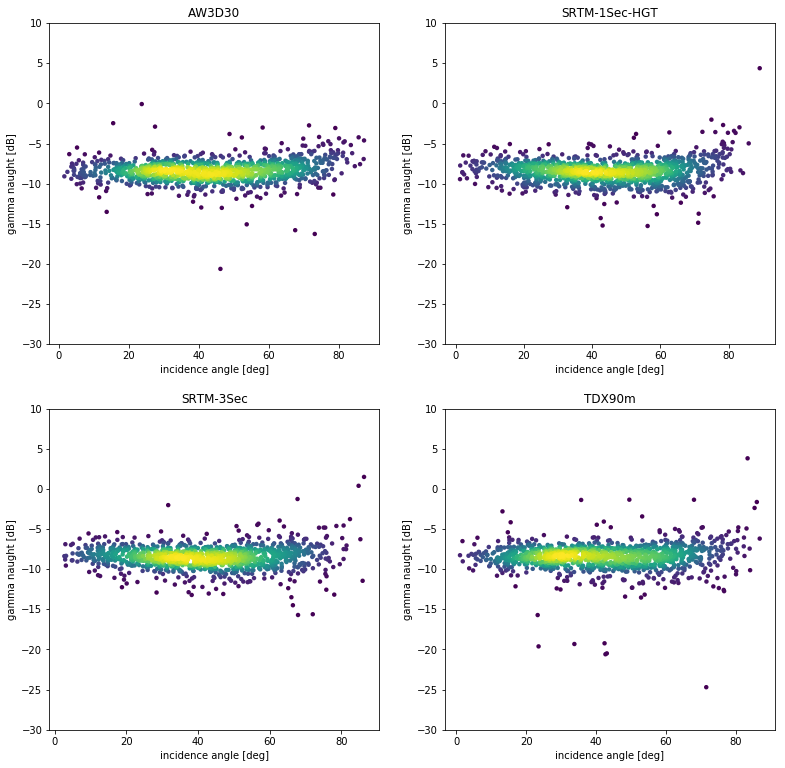

In [8]:
import numpy as np
from S1_ARD import sar_vs_inc
from matplotlib import pyplot as plt
import matplotlib

% matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 13)

i = 1
for dem_id in demfiles.keys():
    scenedir = os.path.join(maindir, 'GAMMA', '{}_{}'.format(id.outname_base(), dem_id))
    print(os.path.basename(scenedir))
    sar = os.path.join(scenedir, '{}_VV_grd_mli_norm_geo_db.tif'.format(id.outname_base()))
    inc = os.path.join(scenedir, '{}_inc_geo.tif'.format(id.outname_base()))
    clc = os.path.join(scenedir, '{}_clc2018_V2018.20b2.tif'.format(id.outname_base()))
    
    with Raster(clc) as ras:
        clc_mat = ras.matrix()
    
    # 311: Broad-leaved forest
    # 312: Coniferous forest
    # 313: Mixed forest
    clc_mask = (clc_mat==311) | (clc_mat==312) | (clc_mat==312)
    
    with Raster(sar) as ras:
        sar_mat = ras.matrix()
    
    with Raster(inc) as ras:
        inc_mat = ras.matrix()
    plt.subplot(2, 2, i)
    
    # alternatively plot the masked backscatter
#     sar_mat[sar_mat == -99] = np.nan
#     sar_mat[~clc_mask] = np.nan
#     plt.imshow(sar_mat)
    
    sar_vs_inc(sar_mat, inc_mat, nsamples=5000, title=dem_id, 
               xlabel='incidence angle [deg]', 
               ylabel='gamma naught [dB]',
               ymin=-30, ymax=10,
               mask=clc_mask)
    i += 1
plt.show()

<a id='todo'></a>
# TODO

- SNAP processing
  * [ ] enable writing ancillary products
- DEM comparison
  * [x] implementation of functions to derive aspect and slope for better visualization
  * [ ] visualize artifacts in e.g. steep terrain
  * [ ] visualize height bias from e.g. lack of ground reference points in photogrammetric DEMs
  * [ ] finish implementation of Cristian's plotting function
- comparison SNAP vs. Gamma
  * compare ancillary products
    + [ ] DEM after EGM correction
    + [ ] local incidence angle
    + [ ] SAR backscatter before and after normalization
    + [ ] comparability in flat terrain
- comparison ascending vs. descending
  * [ ] select and process scene from descending orbit
